<a href="https://colab.research.google.com/github/Venchislav/Neural-Networks/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, LeakyReLU, Dropout, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [34]:
(X_train, _), (X_test, _) = mnist.load_data()

# concatenating X_train and X_test (as we don't give a sh😧t)
X = np.vstack((X_train, X_test))
X = X.astype('float32')
X = (X - 127.5) / 127.5

In [35]:
X.shape

(70000, 28, 28)

In [36]:
def build_generator(n):
  input = Input(shape=(n,))

  x = Dense(256, activation=LeakyReLU(alpha=0.1))(input)
  x = Dense(512, activation=LeakyReLU(alpha=0.1))(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(784, activation='tanh')(x)

  output = Reshape((28, 28, 1))(x)

  return Model(input, output)

In [37]:
def build_discriminator():
  input = Input(shape=(28, 28, 1))

  x = Flatten()(input)
  x = Dropout(0.4)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)

  output = Dense(1, activation='sigmoid')(x)
  model = Model(input, output)
  model.compile(
      optimizer=Adam(),
      loss='binary_crossentropy'
      )
  return model

In [38]:
def gan(gen, disc):
  disc.trainable = False

  model = Sequential([
      gen,
      disc
  ])

  model.compile(
      optimizer=Adam(lr=0.001),
      loss='binary_crossentropy'
  )

  return model

In [39]:
discriminator = build_discriminator()

In [40]:
keras.utils.plot_model(discriminator, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [41]:
generator = build_generator(100)

In [42]:
keras.utils.plot_model(generator, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [43]:
gan_model = gan(generator, discriminator)

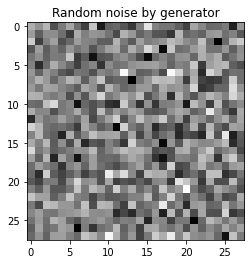

In [44]:
plt.title('Random noise by generator')
plt.imshow(generator.predict(np.random.randn(100).reshape(1, 100))[0], cmap='gray');

c:\Users\rayga\miniconda3\envs\directml\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


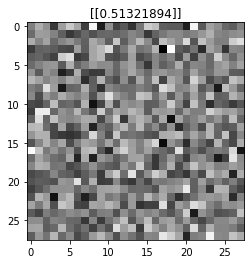

In [45]:
gen_pred = generator.predict(np.random.randn(100).reshape(1, 100)).reshape(28, 28, 1)
plt.title(discriminator.predict(gen_pred.reshape(1, 28, 28, 1)))
plt.imshow(gen_pred, cmap='gray');

In [46]:
from tqdm import tqdm

In [47]:
epochs = 200
batch_size = 256
half_batch = batch_size // 2
n = 100
losses = []

epoch 0 ---- losses[d/g]: [7.861437e-05, 44.999866]
epoch 1 ---- losses[d/g]: [8.482629e-06, 67.403854]
epoch 2 ---- losses[d/g]: [1.6725257e-06, 80.1097]
epoch 3 ---- losses[d/g]: [2.3189787e-07, 62.61786]
epoch 4 ---- losses[d/g]: [4.446968e-07, 72.56815]
epoch 5 ---- losses[d/g]: [3.9160648e-07, 66.53633]
epoch 6 ---- losses[d/g]: [4.1443776e-08, 78.50017]
epoch 7 ---- losses[d/g]: [0.08856341, 33.40084]
epoch 8 ---- losses[d/g]: [2.1613447e-05, 94.19122]
epoch 9 ---- losses[d/g]: [8.3818904e-08, 95.2845]
epoch 10 ---- losses[d/g]: [6.519248e-08, 90.48726]
epoch 11 ---- losses[d/g]: [2.7939675e-09, 85.6053]
epoch 12 ---- losses[d/g]: [9.4570817e-07, 100.72798]
epoch 13 ---- losses[d/g]: [7.683357e-08, 102.11572]
epoch 14 ---- losses[d/g]: [1.1641523e-08, 93.374435]
epoch 15 ---- losses[d/g]: [3.306192e-08, 103.77596]
epoch 16 ---- losses[d/g]: [1.8160778e-08, 104.84533]
epoch 17 ---- losses[d/g]: [2.7379187e-06, 130.07785]
epoch 18 ---- losses[d/g]: [2.3748694e-08, 155.50876]
epoch 

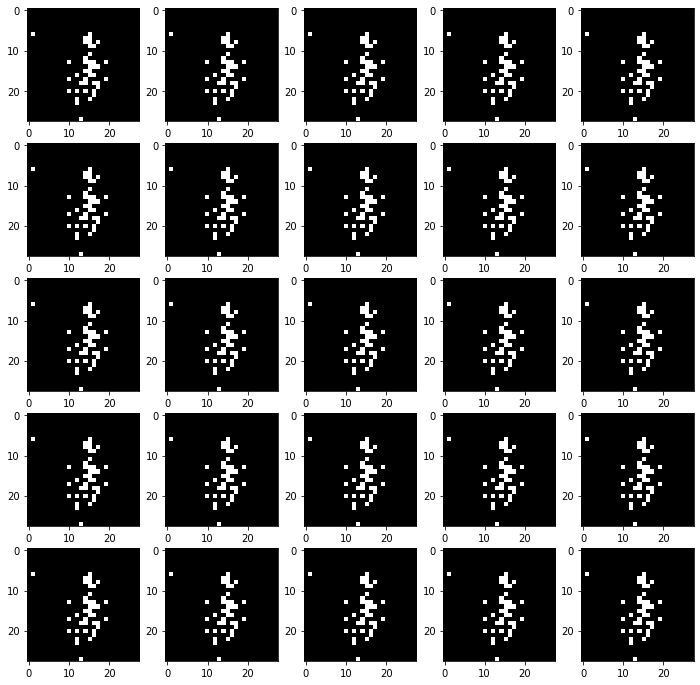

In [48]:
for i in range(epochs):
  for j in range(len(X)//batch_size):
    X_real = X[np.random.randint(0, len(X), half_batch)].reshape(half_batch, 28, 28, 1)
    y_real = np.ones(half_batch).reshape(half_batch, 1)

    X_fake = generator.predict(np.random.randn(half_batch, n), verbose=0)
    y_fake = np.zeros(half_batch).reshape(half_batch, 1)

    X_final = np.vstack((X_real, X_fake))
    y_final = np.vstack((y_real, y_fake))

    dloss = discriminator.train_on_batch(X_final, y_final)
    gloss = gan_model.train_on_batch(np.random.randn(batch_size, n), np.ones(batch_size).reshape(batch_size, 1))

    losses.append([dloss, gloss])
  print(f'epoch {i} ---- losses[d/g]: {losses[-1]}')

ip, axes = plt.subplots(5, 5, figsize=(12, 12))
for ii in range(5):
  for jj in range(5):
    axes[ii, jj].imshow(generator.predict(np.random.randn(n).reshape(1, n), verbose=0).reshape(28, 28, 1), cmap='gray')

plt.show();

In [68]:
noises = list([np.random.randn(1, n) for i in range(25)])

In [76]:
preds = []

for i in range(len(noises)):
    preds.append(generator.predict(noises[i]))

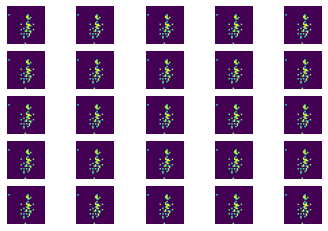

In [78]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(preds[i][0])

**UPD FOR PIGGIES:** <br>
**I INSTALLED DIRECT-ML TENSORFLOW, SO I HAVE GPU WORKING NOW!**<BR>
**I TRAINED THIS IN 1.5 MINS INSTEAD OF 2 HOURS!!!** <br>
<img src='https://media1.tenor.com/m/tyjBgU7Na0YAAAAd/peter-griffin-racing.gif'>